##  We wish to evaluate the best six football clubs in the world: Real Madrid, Barcelona, Liverpool, Manchester City, PSG and Inter.

### We wish to support the winning odds of each team in a tournament of the best six teams. What we have is past score from previuos years at which this tournament took place.
  
### We want to infer a latent parameter - that is the 'strength' of a team based only on their **scoring intensity**, and all we have are their scores and results, we can't accurately measure the 'strength' of a team.


In [1]:
# imports
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
import itertools
import pandas as pd
import pymc as pm
import seaborn as sns
import pickle as pkl
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## The input   looks like as follows:

In [2]:
group = 15
df_all  = pkl.load(open('/content/drive/MyDrive/Bayesian_programming/project_25_Q/data_teams/group_'+str(group) + '.pkl', 'rb'))
df_all.sample(5)

,home_team,away_team,home_score,away_score,year
21,Barca,Real,3,5,2015
22,PSG,Inter,2,5,2015
41,Barca,PSG,5,4,2016
32,ManC,Inter,3,4,2016
24,Inter,ManC,4,4,2015


## We have home and away team, we have score and year.

## What is our goal?

### Our goal is to infer the latent variables—specifically, each team's strength—that give rise to the observed data, namely the scorelines. Since scorelines provide a noisy signal of team strength, we seek a model that allows us to effectively quantify the uncertainty surrounding these underlying strengths.



## Part 1

### We start by conducting an exploratory data analysis to gain an initial understanding of the underlying patterns and structure in the data.

## Tasks



### 1. (4%) Select your favorite team and compare its goal difference in home versus away matches. Is the team performing better at home or away? Visualize this by plotting a bar chart showing the goal difference for both home and away games.

### 2. (4%) Identify the team with the highest 75th percentile performance in away games. For each team, calculate the goal difference for all away matches (goals scored minus goals against) and determine the 75th value. Which team comes out on top?

### 3. (4%) Create a bar chart showing the goal difference for each team (i.e., total goals scored minus total goals against). Based on this plot, which team appears to be the strongest, and which one the weakest?

### 4. (4%) Generate the same bar chart over time for each team. Do any teams exhibit a clear trend, either improving or declining in performance?

In [3]:
import warnings
warnings.filterwarnings('ignore')

## **EDA**

### **1) Home vs. Away**

In [4]:
df_all['home_goal_diff'] = df_all['home_score'] - df_all['away_score']
df_all['away_goal_diff'] = df_all['away_score'] - df_all['home_score']

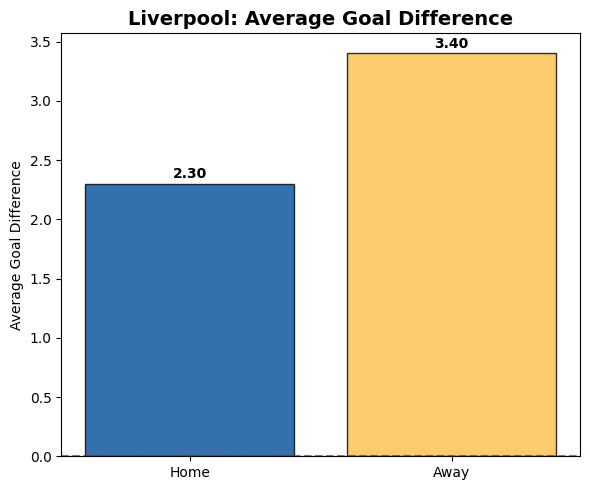

Liverpool performs better away (diff: 1.10 goals/match)


In [5]:
team_name = 'Liverpool'
# Separate home and away matches
home_matches = df_all[df_all['home_team'] == team_name]
away_matches = df_all[df_all['away_team'] == team_name]

# Calculate average goal differences
avg_home = home_matches['home_goal_diff'].mean()
avg_away = away_matches['away_goal_diff'].mean()

# Create bar chart
plt.figure(figsize=(6, 5))
venues = ['Home', 'Away']
values = [avg_home, avg_away]
colors = ['#004d98', '#fcbf49']

bars = plt.bar(venues, values, color=colors, alpha=0.8, edgecolor='black')
plt.title(f'{team_name}: Average Goal Difference', fontsize=14, fontweight='bold')
plt.ylabel('Average Goal Difference')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Add value labels
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.05,
             f'{value:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
better = 'home' if avg_home > avg_away else 'away'
print(f"{team_name} performs better {better} (diff: {abs(avg_home - avg_away):.2f} goals/match)")

## **2) Away Score**

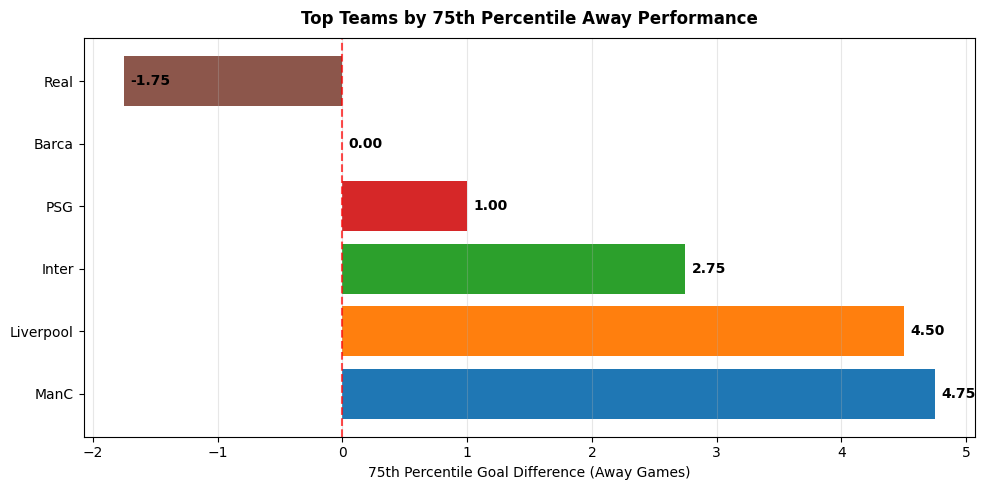

Top teams by 75th percentile away performance:
ManC: 4.75
Liverpool: 4.50
Inter: 2.75
PSG: 1.00
Barca: 0.00
Real: -1.75

Winner: ManC with 4.75 goal difference


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate goal difference for away matches
away_matches = df_all.copy()
away_matches['away_goal_diff'] = away_matches['away_score'] - away_matches['home_score']

# Calculate 75th percentile for each away team
team_75th = away_matches.groupby('away_team')['away_goal_diff'].quantile(0.75).reset_index()
team_75th.columns = ['team', '75th_percentile']
team_75th = team_75th.sort_values('75th_percentile', ascending=False)

# Create visualization
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
plt.figure(figsize=(10, 5))
bars = plt.barh(range(len(team_75th)), team_75th['75th_percentile'],
                color=colors)

plt.yticks(range(len(team_75th)), team_75th['team'])
plt.xlabel('75th Percentile Goal Difference (Away Games)')
plt.title('Top Teams by 75th Percentile Away Performance', fontweight='bold', pad=10)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, team_75th['75th_percentile'])):
    plt.text(value + 0.05, bar.get_y() + bar.get_height()/2,
             f'{value:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Show results
print("Top teams by 75th percentile away performance:")
for i, row in team_75th.iterrows():
    print(f"{row['team']}: {row['75th_percentile']:.2f}")

print(f"\nWinner: {team_75th.iloc[0]['team']} with {team_75th.iloc[0]['75th_percentile']:.2f} goal difference")

## **3) Goal Difference for each Team**

In [7]:
# Calculate total goals for each team (home and away combined)
home_stats = df_all.groupby('home_team').agg({
    'home_score': 'sum',
    'away_score': 'sum'
}).rename(columns={'home_score': 'goals_scored_home', 'away_score': 'goals_against_home'})

away_stats = df_all.groupby('away_team').agg({
    'away_score': 'sum',
    'home_score': 'sum'
}).rename(columns={'away_score': 'goals_scored_away', 'home_score': 'goals_against_away'})

# Combine home and away stats
team_stats = pd.concat([
    home_stats.rename_axis('team'),
    away_stats.rename_axis('team')
], axis=1, sort=False).fillna(0)

# Calculate total goals scored and against
team_stats['total_goals_scored'] = team_stats['goals_scored_home'] + team_stats['goals_scored_away']
team_stats['total_goals_against'] = team_stats['goals_against_home'] + team_stats['goals_against_away']
team_stats['goal_difference'] = team_stats['total_goals_scored'] - team_stats['total_goals_against']

# Sort by goal difference
team_stats = team_stats.sort_values('goal_difference', ascending=True)
team_stats

,goals_scored_home,goals_against_home,goals_scored_away,goals_against_away,total_goals_scored,total_goals_against,goal_difference
team,,,,,,,
Real,21,98,29,71,50,169,-119
Barca,33,45,40,59,73,104,-31
PSG,38,42,44,39,82,81,1
Inter,54,30,54,38,108,68,40
ManC,51,23,53,29,104,52,52
Liverpool,63,40,58,24,121,64,57


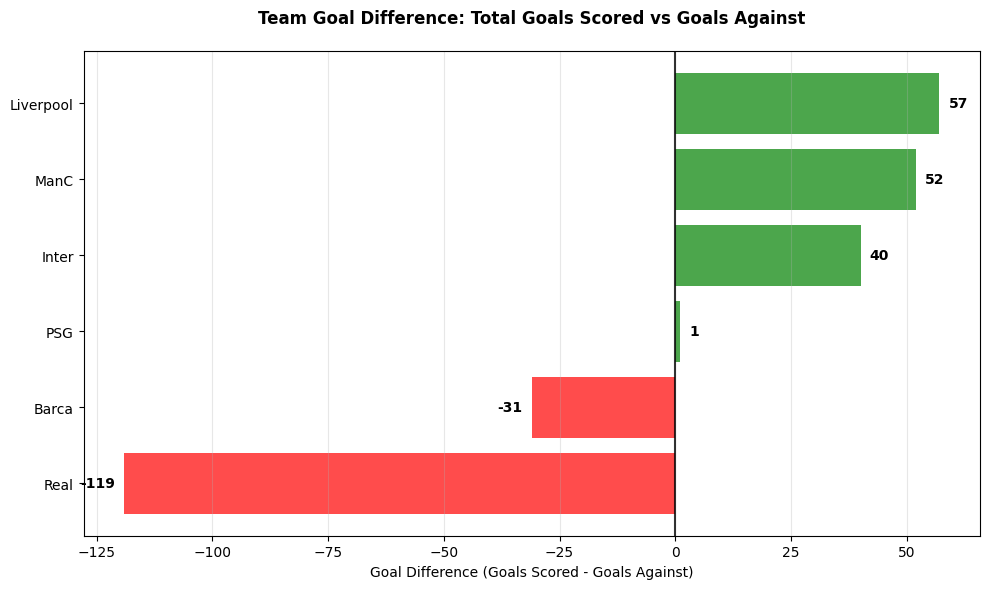

Strongest team: Liverpool (+57)
Weakest team: Real (-119)

Top 3: Liverpool, ManC, Inter
Bottom 3: Real, Barca, PSG


In [8]:
# Create horizontal bar chart
plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in team_stats['goal_difference']]
bars = plt.barh(range(len(team_stats)), team_stats['goal_difference'], color=colors, alpha=0.7)

plt.yticks(range(len(team_stats)), team_stats.index)
plt.xlabel('Goal Difference (Goals Scored - Goals Against)')
plt.title('Team Goal Difference: Total Goals Scored vs Goals Against', fontweight='bold', pad=20)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.8)
plt.grid(axis='x', alpha=0.3)

# Add value labels for top and bottom teams
for i, (bar, value) in enumerate(zip(bars, team_stats['goal_difference'])):
    if i < 3 or i >= len(team_stats) - 3:  # Show labels for top 3 and bottom 3
        plt.text(value + (2 if value >= 0 else -2), bar.get_y() + bar.get_height()/2,
                f'{int(value)}', va='center', ha='left' if value >= 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()

# Results
strongest = team_stats.index[-1]
weakest = team_stats.index[0]
print(f"Strongest team: {strongest} (+{int(team_stats.loc[strongest, 'goal_difference'])})")
print(f"Weakest team: {weakest} ({int(team_stats.loc[weakest, 'goal_difference'])})")

# Top 3 and bottom 3
print(f"\nTop 3: {', '.join(team_stats.index[-3:].tolist()[::-1])}")
print(f"Bottom 3: {', '.join(team_stats.index[:3].tolist())}")

## **4) Trend Analysis**

In [9]:
# Calculate goal difference for each team per year
def calculate_yearly_goal_diff(df):
    results = []
    for year in df['year'].unique():
        year_data = df[df['year'] == year]
        teams = set(year_data['home_team'].tolist() + year_data['away_team'].tolist())

        for team in teams:
            goals_for = 0
            goals_against = 0

            # Home matches
            home_matches = year_data[year_data['home_team'] == team]
            goals_for += home_matches['home_score'].sum()
            goals_against += home_matches['away_score'].sum()

            # Away matches
            away_matches = year_data[year_data['away_team'] == team]
            goals_for += away_matches['away_score'].sum()
            goals_against += away_matches['home_score'].sum()

            if goals_for + goals_against > 0:  # Team played this year
                results.append({
                    'year': year,
                    'team': team,
                    'goal_difference': goals_for - goals_against})
    return pd.DataFrame(results)

In [10]:
# Calculate yearly stats
yearly_stats = calculate_yearly_goal_diff(df_all)

# Create pivot table
pivot_data = yearly_stats.pivot(index='year', columns='team', values='goal_difference').fillna(0)

In [11]:
pivot_data

team,Barca,Inter,Liverpool,ManC,PSG,Real
year,,,,,,
2014,-19,9,18,18,-1,-25
2015,-15,14,11,16,1,-27
2016,3,12,16,6,-6,-31
2017,0,5,12,12,7,-36


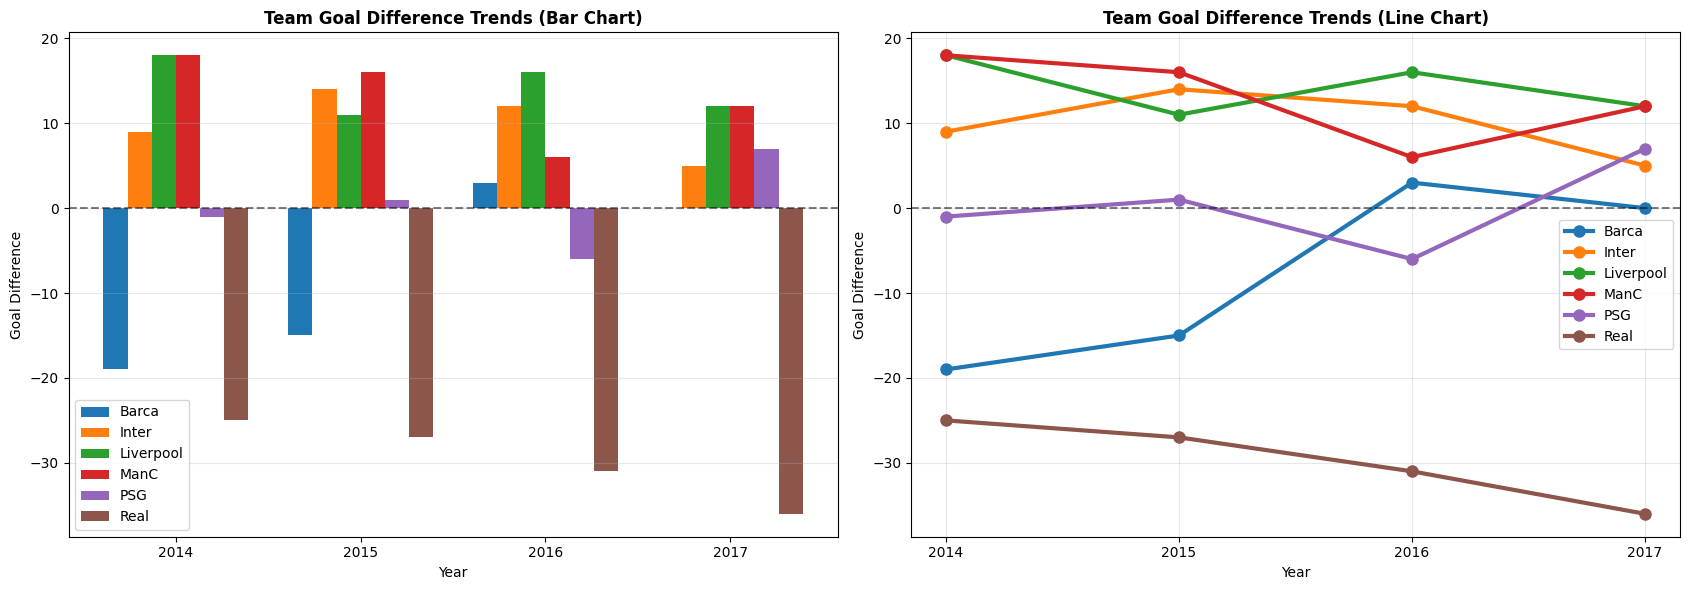

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

# Bar chart (ax1)
x = np.arange(len(pivot_data.index))
width = 0.13
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
for i, team in enumerate(pivot_data.columns):
    ax1.bar(x + i*width, pivot_data[team], width, label=team, color=colors[i % len(colors)])

ax1.set_xlabel('Year')
ax1.set_ylabel('Goal Difference')
ax1.set_title('Team Goal Difference Trends (Bar Chart)', fontweight='bold')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticks(x + width * 2.5)
ax1.set_xticklabels(pivot_data.index)

# Line chart (ax2)
for i, team in enumerate(pivot_data.columns):
    ax2.plot(pivot_data.index, pivot_data[team],
             marker='o', linewidth=3, markersize=8, label=team, color=colors[i % len(colors)])

ax2.set_xlabel('Year')
ax2.set_ylabel('Goal Difference')
ax2.set_title('Team Goal Difference Trends (Line Chart)', fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(pivot_data.index)

plt.tight_layout()
plt.show()

In [13]:
# Calculate trend slopes for teams with multiple years
trend_analysis = {}
for team in pivot_data.columns:
    team_data = pivot_data[team][pivot_data[team] != 0]  # Remove years with no games
    if len(team_data) > 1:
        x = np.array(team_data.index)
        y = team_data.values
        slope = np.polyfit(x, y, 1)[0]
        trend_analysis[team] = slope

if trend_analysis:
    trend_df = pd.DataFrame(list(trend_analysis.items()), columns=['team', 'trend_slope'])
    trend_df = trend_df.sort_values('trend_slope')

    print(f"\nTrend analysis:")
    for _, row in trend_df.iterrows():
        direction = "improving" if row['trend_slope'] > 0 else "declining"
        print(f"{row['team']}: {direction} ({row['trend_slope']:.1f} per year)")
print("\nIt can be noticed in the graphs that Barca clearly improving and Real clearly declining")


Trend analysis:
Real: declining (-3.7 per year)
ManC: declining (-2.8 per year)
Inter: declining (-1.4 per year)
Liverpool: declining (-1.3 per year)
PSG: improving (1.7 per year)
Barca: improving (11.0 per year)

It can be noticed in the graphs that Barca clearly improving and Real clearly declining


## Part 2

## What assumptions do we know for our football competition?

### We know that there are 6 teams, each year all possible pairs playes once.  
### We have data from the last few years
### We also know that in sports scoring is modelled as a Poisson distribution.
### We consider home advantage to be a strong effect in sports

# Poisson regression


    
###   Poisson random variable measures the number of events for a single time unit
    
$$ Y\sim Pois(\lambda) $$
    
$$ P(Y=y) = \frac{e^{-\lambda}\lambda^y}{y!} $$
    
$$ E[Y] = V[Y] =\lambda $$
    

    
##  Poisson regression model looks like this:

## $$ (1) \quad  E[Y_i] = \lambda_i = e^{b_0 + b_1 X_{i,1} + b_2 X_{i,2}+...+ b_n X_{i,n}} $$
    
## $$  (2)  \quad  Log(E[Y_i]) = Log(\lambda_i) = b_0 + b_1 X_{i,1} + b_2 X_{i,2}+...+ b_n X_{i,n} $$
    
## $$ (3) \quad  Y_i ~\sim Pois(\lambda_i) $$
    
## i: the index of the instance we wish to infer
## $Y_i$: the value we wish to predict.
## $\lambda_i$: the expect value we wish to predict.
## $X_{i,j}$ the value of $i^{th}$ instace and the $j^{th}$ feature.
## $b_j$ is the parameter of the  $j^{th}$ feature.


## The model.

### The league is made up by a total of six teams, playing each other once in a season.

### The number of goals scored by the home and the away teams in the g-th game of the season (15 games) are notated by $y_{g_1}$ and $y_{g_2}$ respectively. </p>
### The vector of observed goal counts $\mathbb{y} = (y_{g_1}, y_{g_2})$ is modelled as independent Poisson:
## $$y_{g_j}| \delta{g_j} \tilde\;\;  Poisson(\delta{g_j})$$
### where the $\delta$ parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>

## We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
### $$ log \delta_{g_1} = intercept + home + \hat{att}_{h(g)} + \hat{def}_{a(g)} $$
### $$ log \delta_{g_2} = intercept + \hat{att}_{a(g)} + \hat{def}_{h(g)}$$


## Alternatively:

### $$  \delta_{g_1} = e^{ home + \hat{att}_{h(g)} + \hat{def}_{a(g)}} $$
### $$  \delta_{g_2} = e^{\hat{att}_{a(g)} + \hat{def}_{h(g)}}$$

### $\hat{att}_{h(g)}$ is the attack effect of a team.
### $\hat{def}_{h(g)}$ is the defense effect of a team.

### For team  i = 1, ..., 6, both  $\hat{att}_{i}$ and $\hat{def}_{i}$ are normalized values, fomrally:

### $$ \hat{att}_{i} = att_i - \bar{att} $$
### $$ \hat{def}_{i} = def_i - \bar{def} $$

where,

### $$ \bar{att}  = \frac{\sum_{i=1}^6 att_i}{6} $$
### $$ \bar{def}  = \frac{\sum_{i=1}^6 def_i}{6} $$

### Just for clarification: suppose we index teams as follows:
### 1: Real Madrid
### 2: Barcelona
### 3: Liverpool
### 4: Manchester City
### 5: PSG
### 6: Inter

### Now, suppose the first game is Real Madrid hosting Barcelona.
### Thus, $h(1) = 1 $ (i.e.,Real Madrid ) and $a(1) = 2 $ (i.e., Barcelona).

### The parameter home represents the advantage for the team hosting the game and we assume that this effect is constant for all the teams and throughout the season
### The scoring intensity is determined jointly by the attack and defense ability of the two teams involved, represented by the parameters att and def, respectively

### Conversely, for each i = 1, ..., 6, the player-specific effects are modelled as exchangeable from a common distribution:

### $att_{i} \; \tilde\;\; Normal(0,\tau_{att})$ and $def_{i} \; \tilde\;\;Normal(0,\tau_{def})$

### The log function to away scores and home scores is a standard trick in the sports analytics literature

## Tasks

### 1. (10%) Build a Hierarchical model with PyMc where you obtain a posterior of the latent variables: $home$, $att_i$,  and $def_i$ for $i = \{1,2,3,4,5,6\} $.
### Remark: Set the MCMC configuration regarding the number of draws, such that there will 4000 samples in total.



## guidence:
###  For the Hierarchical model, connect the different teams only via the attack and defence std (i.e., $\tau_{att}$ and $\tau_{def}$) and not the mean value.

## Indexing the data for the pymc model

In [14]:
df_all.head()

,home_team,away_team,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Inter,Real,4,3,2014,1,-1
1,PSG,Liverpool,5,6,2014,-1,1
2,ManC,Barca,5,1,2014,4,-4
3,ManC,Inter,5,0,2014,5,-5
4,Barca,Liverpool,0,5,2014,-5,5


In [15]:
## for your convinience we have here the home and away index with respect to df_all.
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)


In [16]:
df_all.head()

,home_team,away_team,home_score,away_score,year,home_goal_diff,away_goal_diff
0,Inter,Real,4,3,2014,1,-1
1,PSG,Liverpool,5,6,2014,-1,1
2,ManC,Barca,5,1,2014,4,-4
3,ManC,Inter,5,0,2014,5,-5
4,Barca,Liverpool,0,5,2014,-5,5


In [17]:
teams

Index(['Barca', 'Inter', 'Liverpool', 'ManC', 'PSG', 'Real'], dtype='object')

In [18]:
home_idx

array([1, 4, 3, 3, 0, 4, 1, 5, 2, 3, 0, 2, 5, 1, 4, 1, 5, 4, 2, 3, 0, 0,
       4, 3, 1, 2, 5, 5, 0, 2, 4, 0, 3, 4, 1, 5, 1, 5, 2, 3, 2, 0, 1, 3,
       4, 0, 2, 5, 5, 1, 4, 0, 3, 2, 1, 5, 2, 0, 4, 3])

In [19]:
away_idx

array([5, 2, 0, 1, 2, 5, 4, 0, 3, 5, 4, 1, 2, 0, 3, 2, 3, 0, 5, 4, 1, 5,
       1, 2, 3, 0, 4, 1, 3, 4, 5, 2, 1, 3, 0, 2, 4, 0, 3, 5, 1, 4, 5, 0,
       2, 3, 4, 1, 3, 2, 0, 1, 4, 5, 3, 4, 0, 5, 1, 2])

In [20]:
coords = {"team": teams, 'home_idx': home_idx, 'away_idx': away_idx}

with pm.Model(coords=coords) as football_model:

    # Hyperpriors
    tau_att = pm.HalfNormal("tau_att", sigma=1.0)
    tau_def = pm.HalfNormal("tau_def", sigma=1.0)

    # Priors
    home = pm.Normal("home", mu=0, sigma=1.0)
    att = pm.Normal("att", mu=0, sigma=tau_att, dims="team")
    def_ = pm.Normal("def", mu=0, sigma=tau_def, dims="team")

    # Centered data
    att_centered = att - pm.math.mean(att)
    def_centered = def_ - pm.math.mean(def_)

    # Rate models
    home_score = home + att_centered[home_idx] + def_centered[away_idx]
    away_score = att_centered[away_idx] + def_centered[home_idx]

    # Exp Rate models
    delta_g1 = pm.math.exp(home_score)
    delta_g2 = pm.math.exp(away_score)

    # Data likelihood for home and away
    y1_likelihood = pm.Poisson("y1_obs", mu=delta_g1, observed=df_all["home_score"])
    y2_likelihood = pm.Poisson("y2_obs", mu=delta_g2, observed=df_all["away_score"])

    # MCMC sampling - 4000 total samples
    trace = pm.sample(draws=2000, tune=2000, chains=2, random_seed=42)

Output()

In [21]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

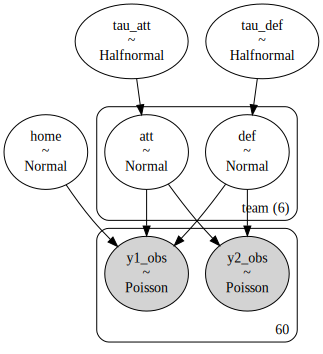

In [22]:
pm.model_to_graphviz(football_model)

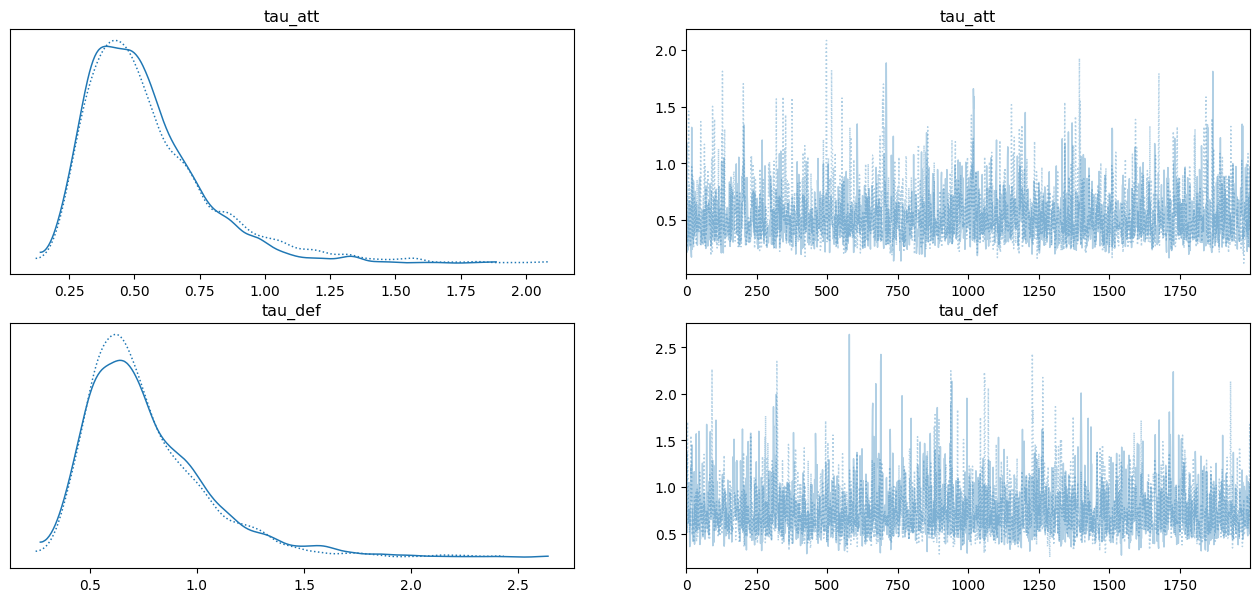

In [23]:
az.plot_trace(trace, var_names=['tau_att','tau_def'],figsize=(16,7));

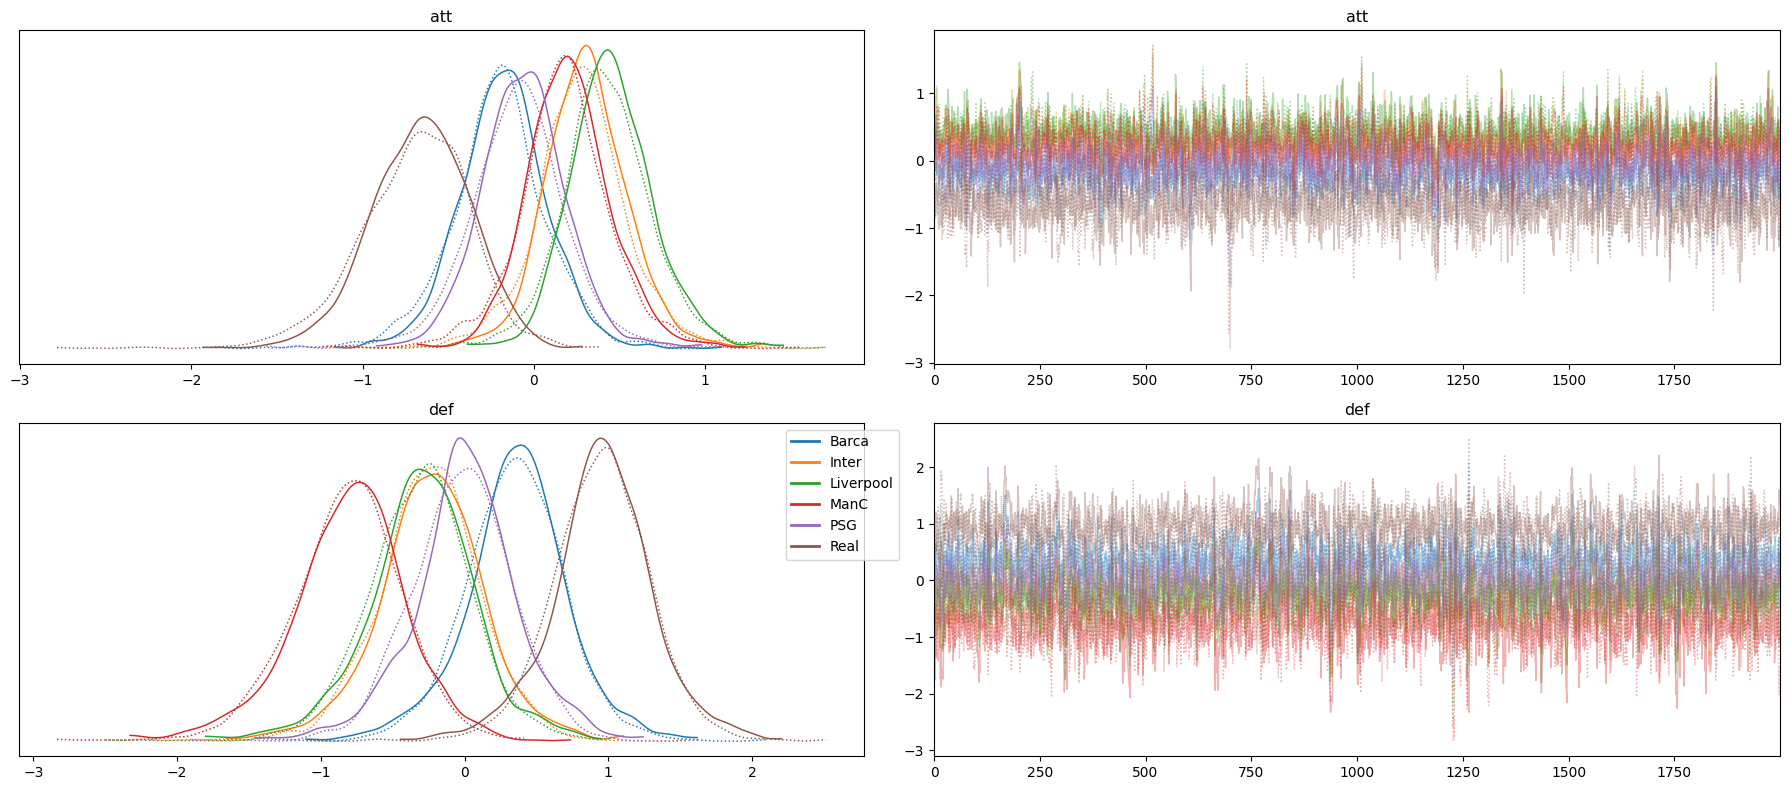

In [24]:
fig, axes = az.plot_trace(trace, var_names=['att', 'def'],
                         coords={'team': teams},
                         figsize=(18, 8))

# Add legend mapping colors to teams
colors = plt.cm.tab10(range(len(teams)))
for i, (team, color) in enumerate(zip(teams, colors)):
    axes[0].plot([], [], color=color, label=team, linewidth=2)

axes[0].legend(bbox_to_anchor=(1.05, 1), loc='best')
plt.tight_layout()
plt.show()

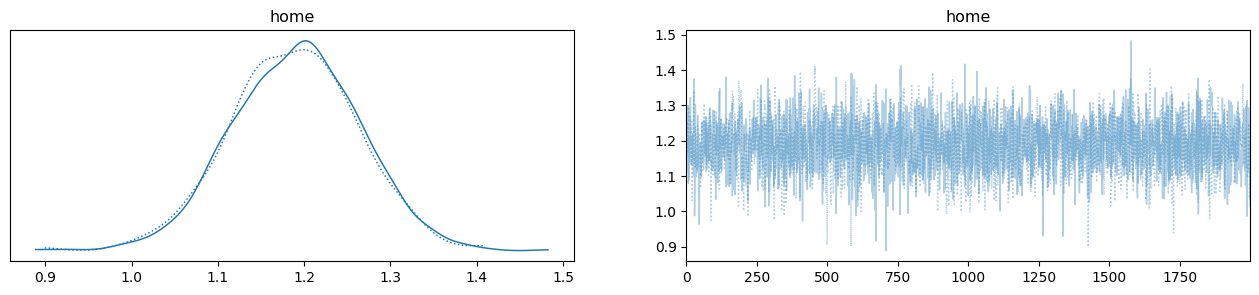

In [25]:
az.plot_trace(trace, var_names=['home'],figsize=(16,3));

## Part 3

## We aim to understand the different distributions of attacking strength and defensive strength.
## These are probabilistic estimates and help us better understand the uncertainty in sports analytics.

## Tasks

### 1. (5%) Plot the attack and defence strenght HDI for each team and compare them. There should be two graphs, one with the attack HDI of all teams and the other with the defence HDI of all teams.  Which team has the best offence and which has the best defence? who has the worst offence and defence? Does these results is aligned with part 1 analysis?

### 2. (5%) Suppose Inter is hosting PSG for a game. What is the probability that PSG will score more than 3 goals?

### 3. (5%) What is the probability that Liverpool will host Barceolna and win by exactly 2 goals?

### 4. (5%) Simulate who wins over a total of 4000 simulations, one per sample in the posterior. Hint: use the sample_posterior_predictive function.
### The resulting simulation should give you the score per each game for all possible combinations for 4 seasons. For each sample out of the 4000 we can measure who will be ranked 1st, 2nd, etc. The ranking is done as follows:
### If a team wins he gets 3 points, draw a single point and lost 0 points. Sum up the points and you will get a full ranking. If we aggregate the results, we can the probability for each team for each position.

### You are required to draw a bar chart that indicates the probability of all possible ranks for each team.

## **1) Attack and Defence Strenght HDI**

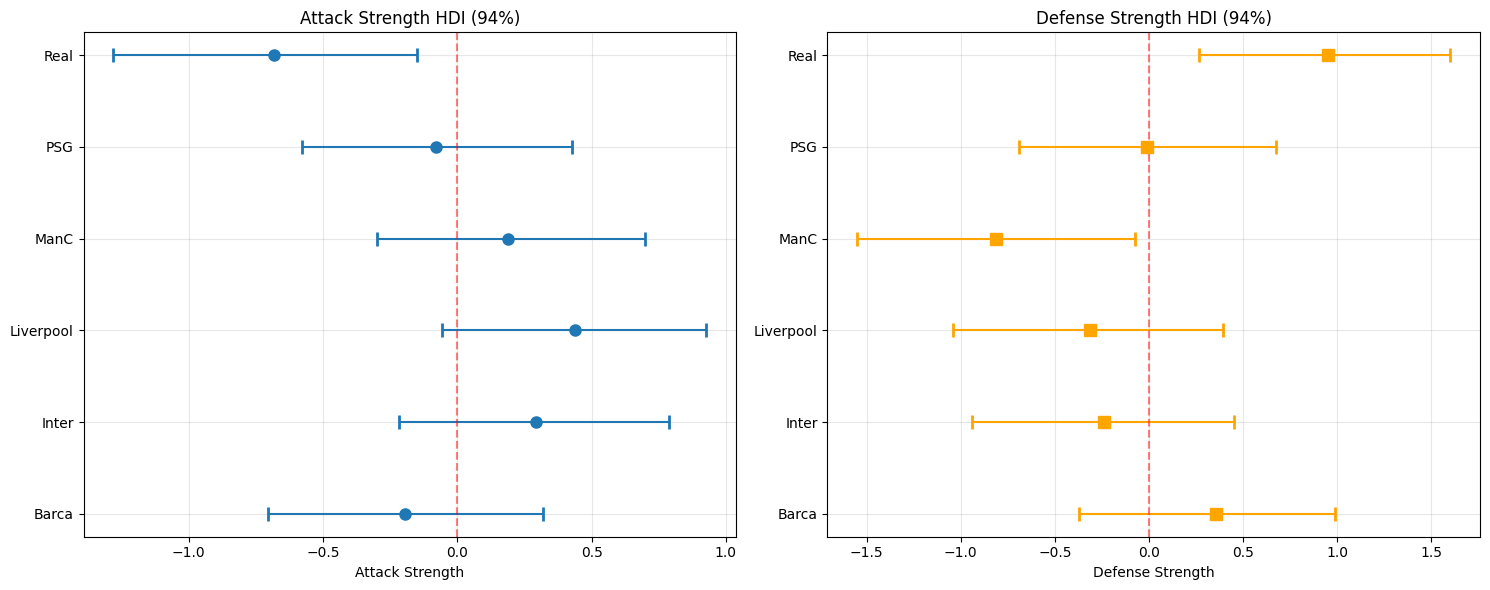

ATTACK ANALYSIS:
Best Attack: Liverpool
Worst Attack: Real

DEFENSE ANALYSIS:
Best Defense: Real
Worst Defense: ManC

Attack Rankings (Best to Worst):
1. Liverpool: 0.438
2. Inter: 0.292
3. ManC: 0.190
4. PSG: -0.078
5. Barca: -0.195
6. Real: -0.683

Defense Rankings (Best to Worst):
1. Real: 0.952
2. Barca: 0.355
3. PSG: -0.009
4. Inter: -0.241
5. Liverpool: -0.311
6. ManC: -0.813

Uncertainty Analysis (HDI width):
Most uncertain attack estimates:
Real: 1.130
Barca: 1.025
Inter: 1.006
Most uncertain defense estimates:
ManC: 1.478
Liverpool: 1.435
Inter: 1.392


In [26]:
# Extract posterior samples for attack and defense
att_samples = trace.posterior["att"].values
def_samples = trace.posterior["def"].values

# Reshape to (samples, teams) for arviz
att_samples_flat = att_samples.reshape(-1, att_samples.shape[-1])
def_samples_flat = def_samples.reshape(-1, def_samples.shape[-1])

# Calculate HDI (94% by default)
att_hdi = az.hdi(att_samples_flat, hdi_prob=0.94)
def_hdi = az.hdi(def_samples_flat, hdi_prob=0.94)

# Team names (assuming same order as in coords)
team_names = teams

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Attack HDI Plot
y_pos = np.arange(len(team_names))
att_means = np.mean(att_samples_flat, axis=0)
att_lower = att_hdi[:, 0]
att_upper = att_hdi[:, 1]

ax1.errorbar(att_means, y_pos,
            xerr=[att_means - att_lower, att_upper - att_means],
            fmt='o', capsize=5, capthick=2, markersize=8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(team_names)
ax1.set_xlabel('Attack Strength')
ax1.set_title('Attack Strength HDI (94%)')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Defense HDI Plot
def_means = np.mean(def_samples_flat, axis=0)
def_lower = def_hdi[:, 0]
def_upper = def_hdi[:, 1]

ax2.errorbar(def_means, y_pos,
            xerr=[def_means - def_lower, def_upper - def_means],
            fmt='s', capsize=5, capthick=2, markersize=8, color='orange')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(team_names)
ax2.set_xlabel('Defense Strength')
ax2.set_title('Defense Strength HDI (94%)')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Analysis
print("ATTACK ANALYSIS:")
print(f"Best Attack: {team_names[np.argmax(att_means)]}")
print(f"Worst Attack: {team_names[np.argmin(att_means)]}")
print()
print("DEFENSE ANALYSIS:")
print(f"Best Defense: {team_names[np.argmax(def_means)]}")
print(f"Worst Defense: {team_names[np.argmin(def_means)]}")
print()

# Detailed rankings
print("Attack Rankings (Best to Worst):")
att_ranking = np.argsort(att_means)[::-1]
for i, team_idx in enumerate(att_ranking):
    print(f"{i+1}. {team_names[team_idx]}: {att_means[team_idx]:.3f}")

print("\nDefense Rankings (Best to Worst):")
def_ranking = np.argsort(def_means)[::-1]
for i, team_idx in enumerate(def_ranking):
    print(f"{i+1}. {team_names[team_idx]}: {def_means[team_idx]:.3f}")

# Print HDI ranges for uncertainty assessment
print("\nUncertainty Analysis (HDI width):")
att_uncertainty = att_upper - att_lower
def_uncertainty = def_upper - def_lower

print("Most uncertain attack estimates:")
att_unc_ranking = np.argsort(att_uncertainty)[::-1]
for i in range(3):
    team_idx = att_unc_ranking[i]
    print(f"{team_names[team_idx]}: {att_uncertainty[team_idx]:.3f}")

print("Most uncertain defense estimates:")
def_unc_ranking = np.argsort(def_uncertainty)[::-1]
for i in range(3):
    team_idx = def_unc_ranking[i]
    print(f"{team_names[team_idx]}: {def_uncertainty[team_idx]:.3f}")

## **2) P(Yg_psg > 3 | h(Inter), a(psg))**

In [27]:
att = trace.posterior["att"].values.reshape(-1, 6)
def_ = trace.posterior["def"].values.reshape(-1, 6)
home = trace.posterior["home"].values.flatten()

att_c = att - att.mean(axis=1, keepdims=True)
def_c = def_ - def_.mean(axis=1, keepdims=True)

In [28]:
# Team indices
inter_idx = np.where(teams == 'Inter')[0][0]
psg_idx = np.where(teams == 'PSG')[0][0]

# PSG away at Inter: P(PSG > 3 goals)
psg_rates = np.exp(att_c[:, psg_idx] + def_c[:, inter_idx])

In [29]:
prob_psg_gt3 = np.mean([1 - poisson.cdf(3, r) for r in psg_rates])

print(f"P(PSG > 3 goals): {prob_psg_gt3:.3f}")

P(PSG > 3 goals): 0.009


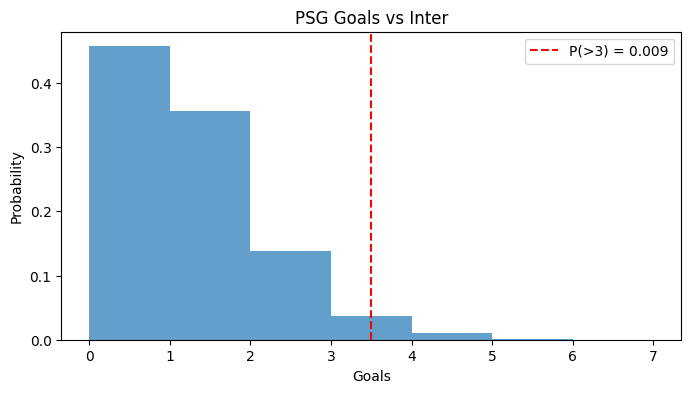

In [30]:
# Visualization
psg_goals = np.concatenate([poisson.rvs(r, size=1) for r in psg_rates[:1000]])
plt.figure(figsize=(8, 4))
plt.hist(psg_goals, bins=range(0, 8), alpha=0.7, density=True)
plt.axvline(3.5, color='red', linestyle='--', label=f'P(>3) = {prob_psg_gt3:.3f}')
plt.title('PSG Goals vs Inter')
plt.xlabel('Goals')
plt.ylabel('Probability')
plt.legend()
plt.show()

## **3) P(Yg_liverpool - Yg_barca = 2 | h(Liverpool), a(Barca))**

In [31]:
liv_idx = np.where(teams == 'Liverpool')[0][0]
bar_idx = np.where(teams == 'Barca')[0][0]

liv_rates = np.exp(home + att_c[:, liv_idx] + def_c[:, bar_idx])
bar_rates = np.exp(att_c[:, bar_idx] + def_c[:, liv_idx])

In [32]:
prob_win_by_2 = np.mean([
    sum(poisson.pmf(liv_goals, lr) * poisson.pmf(liv_goals - 2, br)
        for liv_goals in range(2, 20))  # Start from 2 since Barcelona needs ≥0 goals
    for lr, br in zip(liv_rates, bar_rates)])
print(f"P(Liverpool wins by exactly 2): {prob_win_by_2:.3f}")

P(Liverpool wins by exactly 2): 0.038


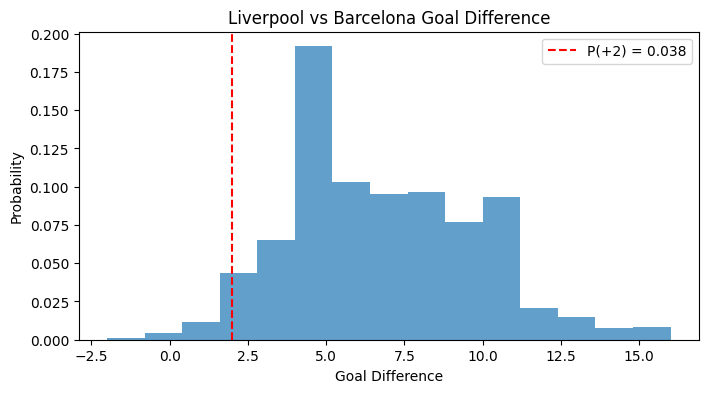

In [33]:
# Visualization
liv_goals = np.concatenate([poisson.rvs(r, size=1) for r in liv_rates[:1000]])
bar_goals = np.concatenate([poisson.rvs(r, size=1) for r in bar_rates[:1000]])
diff = liv_goals - bar_goals

plt.figure(figsize=(8, 4))
plt.hist(diff, bins=15, alpha=0.7, density=True)
plt.axvline(2, color='red', linestyle='--', label=f'P(+2) = {prob_win_by_2:.3f}')
plt.title('Liverpool vs Barcelona Goal Difference')
plt.xlabel('Goal Difference')
plt.ylabel('Probability')
plt.legend()
plt.show()

## **4) League Simulation**

In [34]:
import itertools
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Generate all possible game combinations
games = list(itertools.combinations(range(len(teams)), 2))
n_games = len(games)
home_teams = np.array([g[0] for g in games])
away_teams = np.array([g[1] for g in games])

with pm.Model() as season_model:
    # Use posterior means from trace
    home_mean = float(trace.posterior["home"].mean().values)
    att_mean = trace.posterior["att"].mean(dim=["chain", "draw"]).values
    def_mean = trace.posterior["def"].mean(dim=["chain", "draw"]).values

    # Center parameters
    att_centered = att_mean - att_mean.mean()
    def_centered = def_mean - def_mean.mean()

    # Season rates
    home_rate = pm.math.exp(home_mean + att_centered[home_teams] + def_centered[away_teams])
    away_rate = pm.math.exp(att_centered[away_teams] + def_centered[home_teams])

    season_home = pm.Poisson("season_home", mu=home_rate)
    season_away = pm.Poisson("season_away", mu=away_rate)

    # Sample 4000 seasons using posterior
    ppc = pm.sample_posterior_predictive(trace, var_names=["season_home", "season_away"], predictions=True)

# Extract scores
home_scores = ppc.predictions["season_home"].values.reshape(-1, n_games)
away_scores = ppc.predictions["season_away"].values.reshape(-1, n_games)

print(f"Simulation shape: {home_scores.shape}")

Output()

Simulation shape: (4000, 15)


In [35]:
# Calculate points for each simulation
n_simulations = home_scores.shape[0]
team_rankings = np.zeros((n_simulations, len(teams), len(teams)))  # (sim, team, position)

for sim in range(n_simulations):
    points = np.zeros(len(teams))

    # Calculate points for each game
    for game_idx in range(n_games):
        home_team = home_teams[game_idx]
        away_team = away_teams[game_idx]
        home_score = home_scores[sim, game_idx]
        away_score = away_scores[sim, game_idx]

        if home_score > away_score:  # Home win
            points[home_team] += 3
        elif home_score < away_score:  # Away win
            points[away_team] += 3
        else:  # Draw
            points[home_team] += 1
            points[away_team] += 1

    # Rank teams (higher points = better rank)
    ranking = np.argsort(-points)  # Descending order

    # Record position for each team
    for pos, team in enumerate(ranking):
        team_rankings[sim, team, pos] = 1

# Calculate probabilities for each position
position_probs = np.mean(team_rankings, axis=0)  # (teams, positions)

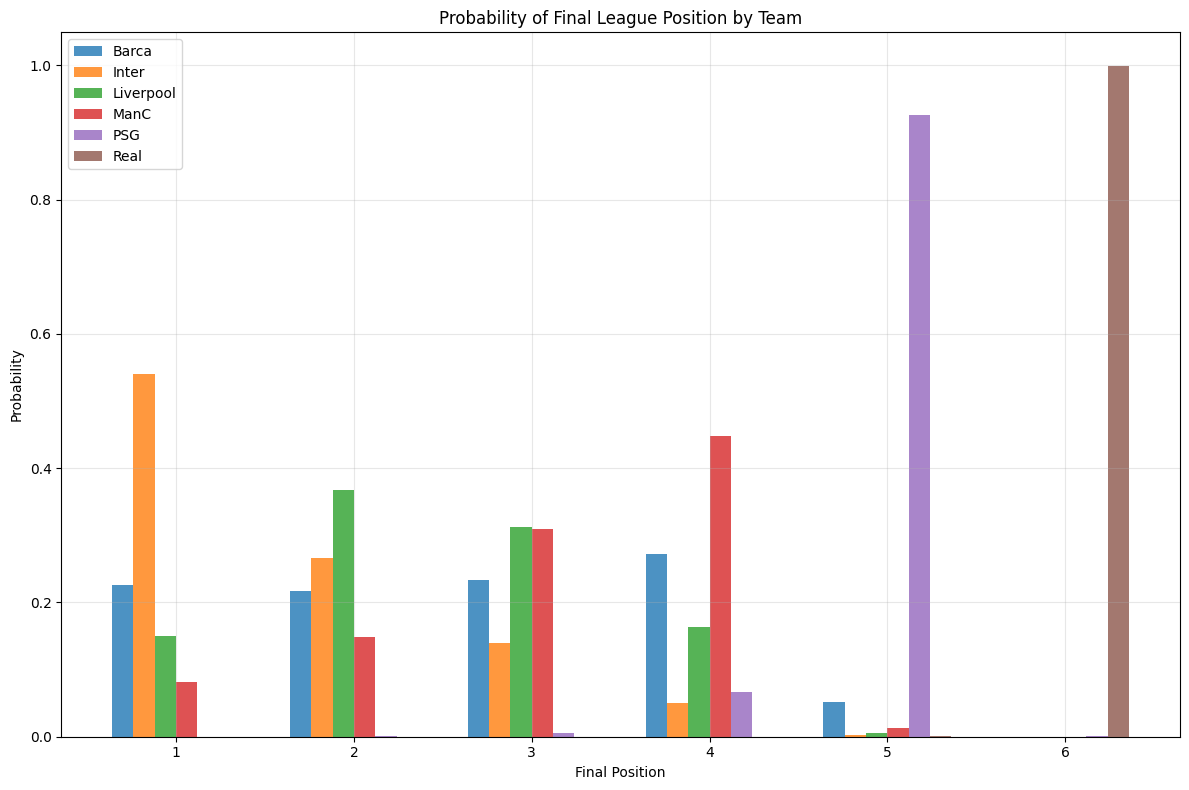

In [36]:
# Create bar chart
fig, ax = plt.subplots(figsize=(12, 8))
positions = np.arange(1, len(teams) + 1)
width = 0.12

for team_idx in range(len(teams)):
    x_pos = positions + team_idx * width - width * (len(teams) - 1) / 2
    ax.bar(x_pos, position_probs[team_idx], width,
           label=teams[team_idx], alpha=0.8)

ax.set_xlabel('Final Position')
ax.set_ylabel('Probability')
ax.set_title('Probability of Final League Position by Team')
ax.set_xticks(positions)
ax.set_xticklabels([f'{i}' for i in positions])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
# Print summary
print("\nFinal Position Probabilities:")
for team_idx, team in enumerate(teams):
    print(f"\n{team}:")
    for pos in range(len(teams)):
        prob = position_probs[team_idx, pos]
        print(f"  Position {pos+1}: {prob:.3f}")

    # Most likely position
    most_likely_pos = np.argmax(position_probs[team_idx]) + 1
    print(f"  Most likely position: {most_likely_pos}")

# Championship probabilities
print(f"\nChampionship Probabilities:")
for team_idx, team in enumerate(teams):
    prob_champion = position_probs[team_idx, 0]
    print(f"{team}: {prob_champion:.4f}")


Final Position Probabilities:

Barca:
  Position 1: 0.227
  Position 2: 0.216
  Position 3: 0.233
  Position 4: 0.272
  Position 5: 0.052
  Position 6: 0.000
  Most likely position: 4

Inter:
  Position 1: 0.540
  Position 2: 0.267
  Position 3: 0.140
  Position 4: 0.051
  Position 5: 0.003
  Position 6: 0.000
  Most likely position: 1

Liverpool:
  Position 1: 0.151
  Position 2: 0.368
  Position 3: 0.312
  Position 4: 0.163
  Position 5: 0.006
  Position 6: 0.000
  Most likely position: 2

ManC:
  Position 1: 0.082
  Position 2: 0.149
  Position 3: 0.310
  Position 4: 0.447
  Position 5: 0.012
  Position 6: 0.000
  Most likely position: 4

PSG:
  Position 1: 0.000
  Position 2: 0.001
  Position 3: 0.005
  Position 4: 0.067
  Position 5: 0.926
  Position 6: 0.001
  Most likely position: 5

Real:
  Position 1: 0.000
  Position 2: 0.000
  Position 3: 0.000
  Position 4: 0.000
  Position 5: 0.001
  Position 6: 0.999
  Most likely position: 6

Championship Probabilities:
Barca: 0.2265
In

---